### 1. Business Understanding

The dataset we will analyze here, consists of information about domestic flights operated by large airlines in the U.S. throughout 2008. It provides details about the schedule and delays of each flight. The data was originally  compiled and made available to the public by the Bureau of Transportation Statistics, but for our purposes we will use the version available at Kaggle: 

[https://www.kaggle.com/giovamata/airlinedelaycauses](https://www.kaggle.com/giovamata/airlinedelaycauses)

Each record provides details about a specific flight, such as its number, origin, destination, airline, scheduled timeline and actual timeline. Information about delays (deviations from the scheduled timeline) is particularly intersting, as it provides us with the opportunity to analyze how delays are related to other factors and how much are domestic flights affected. The results will hopefully provide insights useful to passengers.

In view of the information at hand, we could consider digging for answers to the following questions:

1. What are the major causes of delays and cancellations affecting domestic flights in the U.S.?


2. Which are the best and the worst carriers (airlines) regarding delays and cancellations? Which are the carriers with the less/most cancellations and the shortest/longest delays?


3. Can we identify periods of the year 2008 when delays were particularly long? For instance, days of the week or months of the year.


4. Are there any combinations of variables that appear to determine the expected delay time or probability of cancellation of a flight?


5. Could we estimate the probability of a flight being cancelled based on some of the variables?

The answers we arrive at will hopefully help passengers make more informed decisions in their travels and avoid the inconveniences of getting into a delayed flight. 

### 2. Data Understanding

By invoking the info function on the DataFrame, we see that it contains 1936758 records and 30 variables:

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_flight_delays = pd.read_csv("datasets/DelayedFlights.csv")

print(f"Airline Delays. Records: {df_flight_delays.shape[0]}, variables: {df_flight_delays.shape[1]}")

# Get the size of the dataset, list of the variables with their types
df_flight_delays.info()

Airline Delays. Records: 1936758, variables: 30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
Unnamed: 0           int64
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    floa

The following table provides a description and the type of each variable:

Number | Name | Description | Type
:------: | :---- | :---- | :----
1 | (Unamed) | Sequential record number | Numerical, integer
2 | Year | 2008 | Numerical, integer
3 | Month | Month number (1=January - 12=December) | Numerical, integer
4 | DayofMonth | Day number of the month (1 - 31) | Numerical, integer
5 | DayOfWeek | Day number of the week (1=Monday - 7=Sunday) | Numerical, integer
6 | DepTime | Actual departure time (local, hhmm) | Numerical, integer
7 | CRSDepTime | Scheduled departure time (local, hhmm) | Numerical, integer
8 | ArrTime | Actual arrival time (local, hhmm) | Numerical, integer
9 | CRSArrTime | Scheduled arrival time (local, hhmm) | Numerical, integer
10 | UniqueCarrier | Unique carrier code | Categorical, string
11 | FlightNum | Flight number | Numerical, integer
12 | TailNum | Plane tail number | Categorical, string
13 | ActualElapsedTime | Actual total flight time, in minutes | Numerical, decimal
14 | CRSElapsedTime | Total flight time estimated by the carrier, in minutes | Numerical, decimal
15 | AirTime | Time in the air, in minutes | Numerical, decimal
16 | ArrDelay | Delay to arrive at the destination airport, in minutes | Numerical, decimal
17 | DepDelay | Delay to depart from the origin airport, in minutes | Numerical, decimal
18 | Origin | Origin IATA airport code | Categorical, string
19 | Dest | Destination IATA airport code | Categorical, string
20 | Distance | Travel in miles | Numerical, integer
21 | TaxiIn | Taxi in time (time to roll from the terminal to the runway), in minutes | Numerical, decimal
22 | TaxiOut | Taxi out time (time to roll from the runway to the terminal) in minutes | Numerical, decimal
23 | Cancelled | Was the flight cancelled? | Numerical, boolean
24 | CancellationCode | Reason why flight was cancelled (A=carrier, B=weather, C=NAS, D=security) | Categorical, string
25 | Diverted | Was the flight diverted to another destination? (1=yes, 0=no) | Numerical, integer
26 | CarrierDelay | Delay caused by the carrier, in minutes | Numerical, decimal
27 | WeatherDelay | Delay caused by the weather, in minutes | Numerical, decimal
28 | NASDelay | Delay caused by the NAS (National Airspace System), in minutes | Numerical, decimal
29 | SecurityDelay | Delay caused by security issues, in minutes | Numerical, decimal
30 | LateAircraftDelay | Delay caused by the aircraft arriving late, in minutes | Numerical, decimal

There are five categorical variables: UniqueCarrier, TailNum, Origin, Dest and CancellationCode. The rest are all numerical. However, when performing operations on DepTime, CRSDepTime, ArrTime and CRSArrTime we must bear in mind that these represent times in hour-minute format.

In [81]:
# Get the names of all categorical variables
print(f"Categorical variables: {df_flight_delays.select_dtypes(include=['object']).columns.values}")

Categorical variables: ['UniqueCarrier' 'TailNum' 'Origin' 'Dest' 'CancellationCode']


##### 2.1 Summary statistics

We get an overview of the variables we are interested in analyzing, by computing some summary statistics:

In [98]:
# Variables we aim to draw conclusions about
target_vars = ["ArrDelay", "DepDelay", "Cancelled", "Diverted"]

# Compute summary statistics about these variables, including the 95th and 99th percentiles
df_summary_stats = df_flight_delays[target_vars].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

df_summary_stats

,ArrDelay,DepDelay,Cancelled,Diverted
count,1.928371e+06,1.936758e+06,1.936758e+06,1.936758e+06
mean,4.219988e+01,4.318518e+01,3.268348e-04,4.003598e-03
std,5.678472e+01,5.340250e+01,1.807562e-02,6.314722e-02
min,-1.090000e+02,6.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00
50%,2.400000e+01,2.400000e+01,0.000000e+00,0.000000e+00
75%,5.600000e+01,5.300000e+01,0.000000e+00,0.000000e+00
95%,1.480000e+02,1.430000e+02,0.000000e+00,0.000000e+00
99%,2.560000e+02,2.490000e+02,0.000000e+00,0.000000e+00
max,2.461000e+03,2.467000e+03,1.000000e+00,1.000000e+00


The fact that the 99th percentile is at least an order of magnitude lower than the maximum, for both delay variables, suggests that these contain a few quite heavy outliers. 

We verify this by assigning a value slightly above the 99th percentile to all outliers beyond that point and then plotting the results. This has the effect of "compressing" the most extreme outliers in a single spot, which in turn prevents the plots from becoming unreadable.

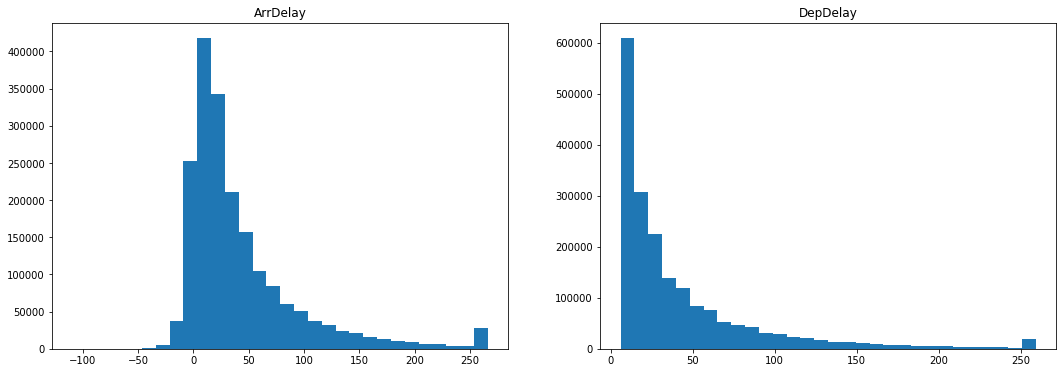

In [107]:
def plot_variable(var, fig_axis):
    """
    INPUT
        var - name of the variable to be plotted
        rows - number of subplots in the container plot
        cols - number of columns in the container plot
        subplot_num - index of the current subplot in the container plot
    OUTPUT
        adds histogram of variable var as a subplot
    """
    outlier_lim = df_summary_stats[var]["99%"]
    
    compressed_outls = df_flight_delays[var].transform(lambda v: v if v <= outlier_lim else (outlier_lim + 10))
    
    fig_axis.hist(compressed_outls, bins=30)
    fig_axis.set_title(var)

    
fig1 = plt.figure(figsize=(18, 6))

axes = fig1.subplots(nrows=1, ncols=2)

for ix, var in enumerate(["ArrDelay", "DepDelay"]):
    plot_variable(var, axes[ix])

plt.show()

In both histograms the last bar represents the outliers greater than the 99th percentile. As we suspected, there are a very few of them. However, we have to keep in mind these extreme values when using models sensitive to outliers. We can also notice that both of our target variables are considerably right-skewed. The summary statistics also confirm that variables Cancelled and Diverted are boolean, even though they are stored as decimal numbers.

### 3. Data Preparation

Now we will examine the data in search for errors and inconsistencies and modify it as necessary to facilitate analysis.

Note that the first variable (Unamed: 0) just enumerates the rows. It can be safely discarded as it provides no information useful for our analysis. We can also drop the Year variable, as all observations are of the same year (2008) in this version of the dataset.

In [84]:
# Drop the first column, which just provides enumerates the rows. The DataFrame index does so already
df_flight_delays.drop(["Unnamed: 0", "Year"], axis=1, inplace=True)

Now let's check for missing values. We start by counting how many we have in each variable:

In [85]:
def build_nan_data(df):
    """
    INPUT
        df - the dataframe in which this function will count for missing values
    OUTPUT
        dataframe with the names of variables in df as index and two columns: count of missing values in 
        each variable and percent of missing values in each variable
    """
    # Count the total missing entries per column
    df_nan_counts = df.isna().sum()

    # Compute the percentage of missing values per column
    df_nan_percents = (df_nan_counts / df.shape[0]) * 100

    return pd.DataFrame({"# Missing": df_nan_counts, "% Missing": df_nan_percents}, index=df_nan_counts.index)

build_nan_data(df_flight_delays)

,# Missing,% Missing
Month,0,0.000000
DayofMonth,0,0.000000
DayOfWeek,0,0.000000
DepTime,0,0.000000
CRSDepTime,0,0.000000
ArrTime,7110,0.367108
CRSArrTime,0,0.000000
UniqueCarrier,0,0.000000
FlightNum,0,0.000000
TailNum,5,0.000258


Since several of the questions we aim at answering are concerned with the schedule of flights, the variables ArrTime, ActualElapsedTime, CRSElapsedTime, AirTime, ArrDelay, TaxiIn, TaxiOut, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay are particularly interesting to us. Hence, we should examine why do they have missing values and handle them properly.

##### 3.1 Flights with missing ArrTime

Taking a look at some of the flights that have missing ArrTime values, it appears that all of them are either cancelled or diverted.

In [86]:
# Get flights that have ArrTime missing and print the first 5
df_missing_arrtime = df_flight_delays[df_flight_delays["ArrTime"].isna()]
df_missing_arrtime[["Cancelled", "Diverted"]].head(10)

,Cancelled,Diverted
1280,0,1
1372,0,1
1776,0,1
1831,0,1
2244,0,1
2245,0,1
2720,0,1
2831,0,1
3075,0,1
3179,0,1


We can verify if that's really the case by counting how many of such flights are cancelled or diverted.

In [87]:
# Count how many of the flights missing ArrTime were also cancelled or diverted
total_missing_arrtime_diverted_or_cancelled = sum((df_missing_arrtime["Cancelled"] == 1.0) | 
                                                  (df_missing_arrtime["Diverted"] == 1.0))

print(f"Total missing ArrTime: {df_missing_arrtime.shape[0]}. Cancelled/Diverted: {total_missing_arrtime_diverted_or_cancelled}")

Total missing ArrTime: 7110. Cancelled/Diverted: 7110


This means that the dataset does not provide arrival times for flights that were cancelled or diverted. 

##### 3.2 Flights with missing ActualElapsedTime, AirTime and ArrDelay

Interestingly, these three variables have the same number of missing values. This strongly suggests that if a flight is missing the value of any of these variables, it's actually missing the values of all three. We can easily verify this by comparing how many rows have all vs. any of these variables missing.

In [88]:
# Get rows with missing values in any of the variables ActualElapsedTime, AirTime or ArrDelay
df_missing_any_3 = df_flight_delays[(df_flight_delays["ActualElapsedTime"].isna()) |
                                  (df_flight_delays["AirTime"].isna()) |
                                  (df_flight_delays["ArrDelay"].isna()) | df_flight_delays["AirTime"].isna()]

# Get rows with missing values in all of the variables ActualElapsedTime, AirTime and ArrDelay
df_missing_all_3 = df_flight_delays[(df_flight_delays["ActualElapsedTime"].isna()) &
                                  (df_flight_delays["AirTime"].isna()) &
                                  (df_flight_delays["ArrDelay"].isna()) & df_flight_delays["AirTime"].isna()]

print(f"Total missing all ActualElapsedTime, AirTime and ArrDelay: {df_missing_all_3.shape[0]}. Total missing any: {df_missing_any_3.shape[0]}")

Total missing all ActualElapsedTime, AirTime and ArrDelay: 8387. Total missing any: 8387


Moreover, by inspecting the rows we see that apparently all these flights were either cancelled or diverted too. We verify this hunch by counting how many of the flights missing ActualElapsedTime, AirTime and ArrDelay were cancelled or diverted. 

In [89]:
# Count all flights missing the 3 variables and how many among them were either cancelled or diverted
total_missing_3 = df_missing_any_3.shape[0]
total_missing_3_cld_dvrt = sum((df_missing_any_3["Cancelled"] == 1.0) | (df_missing_any_3["Diverted"] == 1.0))

# If these counts are equal, then all flights missing the 3 variables were either cancelled or diverted
were_all_missing_3_cld_dvrt = (total_missing_3 == total_missing_3_cld_dvrt)

print(f"Were all flights missing ActualElapsedTime, AirTime and ArrDelay cancelled or diverted? {were_all_missing_3_cld_dvrt}")

# Count how many flights in total were either cancelled or diverted
total_cld_dvrt = sum((df_flight_delays["Cancelled"] == 1.0) | (df_flight_delays["Diverted"] == 1.0))

print(f"Total flights cancelled or diverted: {total_cld_dvrt}")

Were all flights missing ActualElapsedTime, AirTime and ArrDelay cancelled or diverted? True
Total flights cancelled or diverted: 8387


From 3.1 and 3.2, we conclude that all flights that failed to bring passengers to their intended destination (i.e. flights that were either cancelled or diverted), have missing values for ActualElapsedTime, AirTime and ArrDelay. Furthermore, most of these flights (7110 out of 8387) have missing values for ArrTime. 

These variables are crucial for analyzing delay and duration of successful flights, but are not so useful in the analysis of failed flights. Therefore, we could split the dataset in two groups:

- _Successful flights:_ not cancelled nor diverted. Brought passengers to the intended destination.
- _Failed flights:_ cancelled or diverted. Failed to bring passenders to the intended destination.

In this way, we get a dataset with no values missing for these important variables. Analyzing this dataset of successful flights separately from the dataset of failed flights is easier and less prone to errors.

In [90]:
# Split dataset in successful and failed flights 
df_success_flights = df_flight_delays[(df_flight_delays["Cancelled"] == 0.0) & (df_flight_delays["Diverted"] == 0.0)].copy()
df_failed_flights = df_flight_delays[(df_flight_delays["Cancelled"] == 1.0) | (df_flight_delays["Diverted"] == 1.0)].copy()

print(f"Total flights: {df_flight_delays.shape[0]}. Successful: {df_success_flights.shape[0]}. Failed: {df_failed_flights.shape[0]}")

Total flights: 1936758. Successful: 1928371. Failed: 8387


##### 3.3 Missing values in successful flights

Let's now take a look at the missing values that remain in the dataset of successful flights.

In [91]:
build_nan_data(df_success_flights)

,# Missing,% Missing
Month,0,0.000000
DayofMonth,0,0.000000
DayOfWeek,0,0.000000
DepTime,0,0.000000
CRSDepTime,0,0.000000
ArrTime,0,0.000000
CRSArrTime,0,0.000000
UniqueCarrier,0,0.000000
FlightNum,0,0.000000
TailNum,3,0.000156


There are just three rows with missing TailNum values. This is an insignificant number of rows relative to the size of the dataset, so we can just drop them.

In [92]:
# Drop rows having missing values for the TailNum variable
df_success_flights.dropna(subset=["TailNum"], inplace=True)

Sadly, there are quite a lot of missing values in the categorized delay variables. Each of these variables, ArrDelay, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay has 35.31% of their values missing. These variables provide information about the potential causes for a flight to be delayed and thus, may be very useful in our analysis. For this reason, we impute missing values in these variables as follows:

- Firstly, we get all the flights having values for all the delay category variables.  

In [93]:
# In this part, we care only about delay-related variables
df_all_delay_data = df_success_flights[["ArrDelay", "CarrierDelay", "WeatherDelay", "NASDelay",
                                        "SecurityDelay", "LateAircraftDelay"]]

# Get flights that have complete information about delays
df_flights_full_dly_data = df_all_delay_data[(df_success_flights["ArrDelay"].isna() == False) &
                                             (df_success_flights["CarrierDelay"].isna() == False) &
                                             (df_success_flights["WeatherDelay"].isna() == False) &
                                             (df_success_flights["NASDelay"].isna() == False) &
                                             (df_success_flights["SecurityDelay"].isna() == False) &
                                             (df_success_flights["LateAircraftDelay"].isna() == False)]

print(f"Total flights not missing delay information: {df_flights_full_dly_data.shape[0]}")

Total flights not missing delay information: 1247486


- We use these rows to determine how the total of each type of delay compares to the total arrival delay of all these flights. To do so, we compute the ratio of the accumulated delays of each type to the accumulated arrival delay. The resulting ratios can be used as weights, to split an arrival delay among these five types.

In [94]:
# Accumulate delays of each type and arrival delays for all flights with full delay information
df_delay_totals = df_flights_full_dly_data.sum()

# For the totals of each type of delay, compute the ratio to the total arrival delay
df_dly_weights = df_delay_totals / df_delay_totals["ArrDelay"]

- Finally, we use these weights to impute the delays of each category, based on the arrival delay. We do so for flights missing values for the delay category variables.

In [95]:
# Impute missing values for each delay category variable, by splitting up the arrival delay as to the weights
for var in ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]:
    df_success_flights[var].fillna(df_success_flights["ArrDelay"] * df_dly_weights[var], inplace=True)

# Check that there are no missing values left
build_nan_data(df_success_flights)

,# Missing,% Missing
Month,0,0.0
DayofMonth,0,0.0
DayOfWeek,0,0.0
DepTime,0,0.0
CRSDepTime,0,0.0
ArrTime,0,0.0
CRSArrTime,0,0.0
UniqueCarrier,0,0.0
FlightNum,0,0.0
TailNum,0,0.0


We have cleared all missing values from the dataset of successful flights!

##### 3.4 Missing values in failed flights

Regarding failed flights, we can simply drop all columns related to duration and performance, as these only make sense for flights that took off and arrived at their destination. 

There are also some missing values in variables that may be useful for analyzing failed flights: TailNum and CRSElapsedTime. Since only 0.02% and 2.36% of the failed flights have missing values for these two variables, we can just drop the rows. 

In [96]:
# Check for missing values in the dataset of failed flights
build_nan_data(df_failed_flights)

,# Missing,% Missing
Month,0,0.000000
DayofMonth,0,0.000000
DayOfWeek,0,0.000000
DepTime,0,0.000000
CRSDepTime,0,0.000000
ArrTime,7110,84.774055
CRSArrTime,0,0.000000
UniqueCarrier,0,0.000000
FlightNum,0,0.000000
TailNum,2,0.023846


In [30]:
# Drop columns missing values 
df_failed_flights.drop(columns=["ArrTime", "ActualElapsedTime", "AirTime", "ArrDelay", "TaxiIn", 
                                "TaxiOut", "CarrierDelay", "WeatherDelay", "NASDelay", 
                                "SecurityDelay", "LateAircraftDelay"], inplace=True)

# Drop rows missing TailNum or CRSElapsedTime
df_failed_flights.dropna(subset=["TailNum", "CRSElapsedTime"], inplace=True)

build_nan_data(df_failed_flights)

,# Missing,% Missing
Month,0,0.0
DayofMonth,0,0.0
DayOfWeek,0,0.0
DepTime,0,0.0
CRSDepTime,0,0.0
CRSArrTime,0,0.0
UniqueCarrier,0,0.0
FlightNum,0,0.0
TailNum,0,0.0
CRSElapsedTime,0,0.0


Now the dataset of failed flights is clear of missing values too!

##### 3.5 Results

In summary, as a result of the data preparation process we have two datasets cleared of missing values:

- *df_success_flights:* will be useful to analyze and model flight delays for flights that were carried out.
- *df_failed_flights:* can be used to analyze and model flights that didn't reach their intended destination because of being cancelled or diverted.

We also have the full dataset in *df_flight_delays*, which can still be of use with analysis techniques that can deal with missing values.

### 4. Modeling